In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Exploratory Analysis

In [2]:
data_dir = os.path.join(os.path.curdir, "data")

beer_data = pd.read_csv(os.path.join(data_dir,'cleaned_beer_data.csv'), index_col=0)

In [3]:
beer_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34134 entries,  Illustrated Man Dark Sour with Berries-Independence Brewing Co to ﻿Boji Blue Pale Ale-Okoboji Brewing Company
Data columns (total 15 columns):
ba_score    34134 non-null float64
ratings     34134 non-null int64
reviews     34134 non-null int64
perc_dev    34134 non-null float64
wants       34134 non-null int64
gots        34134 non-null int64
look        34134 non-null float64
smell       34134 non-null float64
taste       34134 non-null float64
feel        34134 non-null float64
link        34134 non-null object
brewery     34134 non-null object
abv         34134 non-null float64
score       34134 non-null float64
style       34134 non-null object
dtypes: float64(8), int64(4), object(3)
memory usage: 4.2+ MB


In [4]:
numeric_beer_data = beer_data.drop(['link', 'brewery', 'style', 'score'], axis=1)

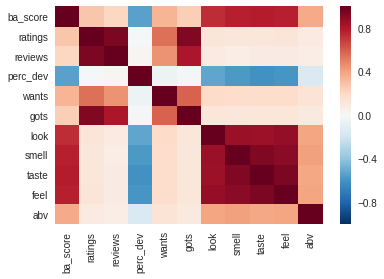

In [5]:
sns.heatmap(numeric_beer_data.corr())

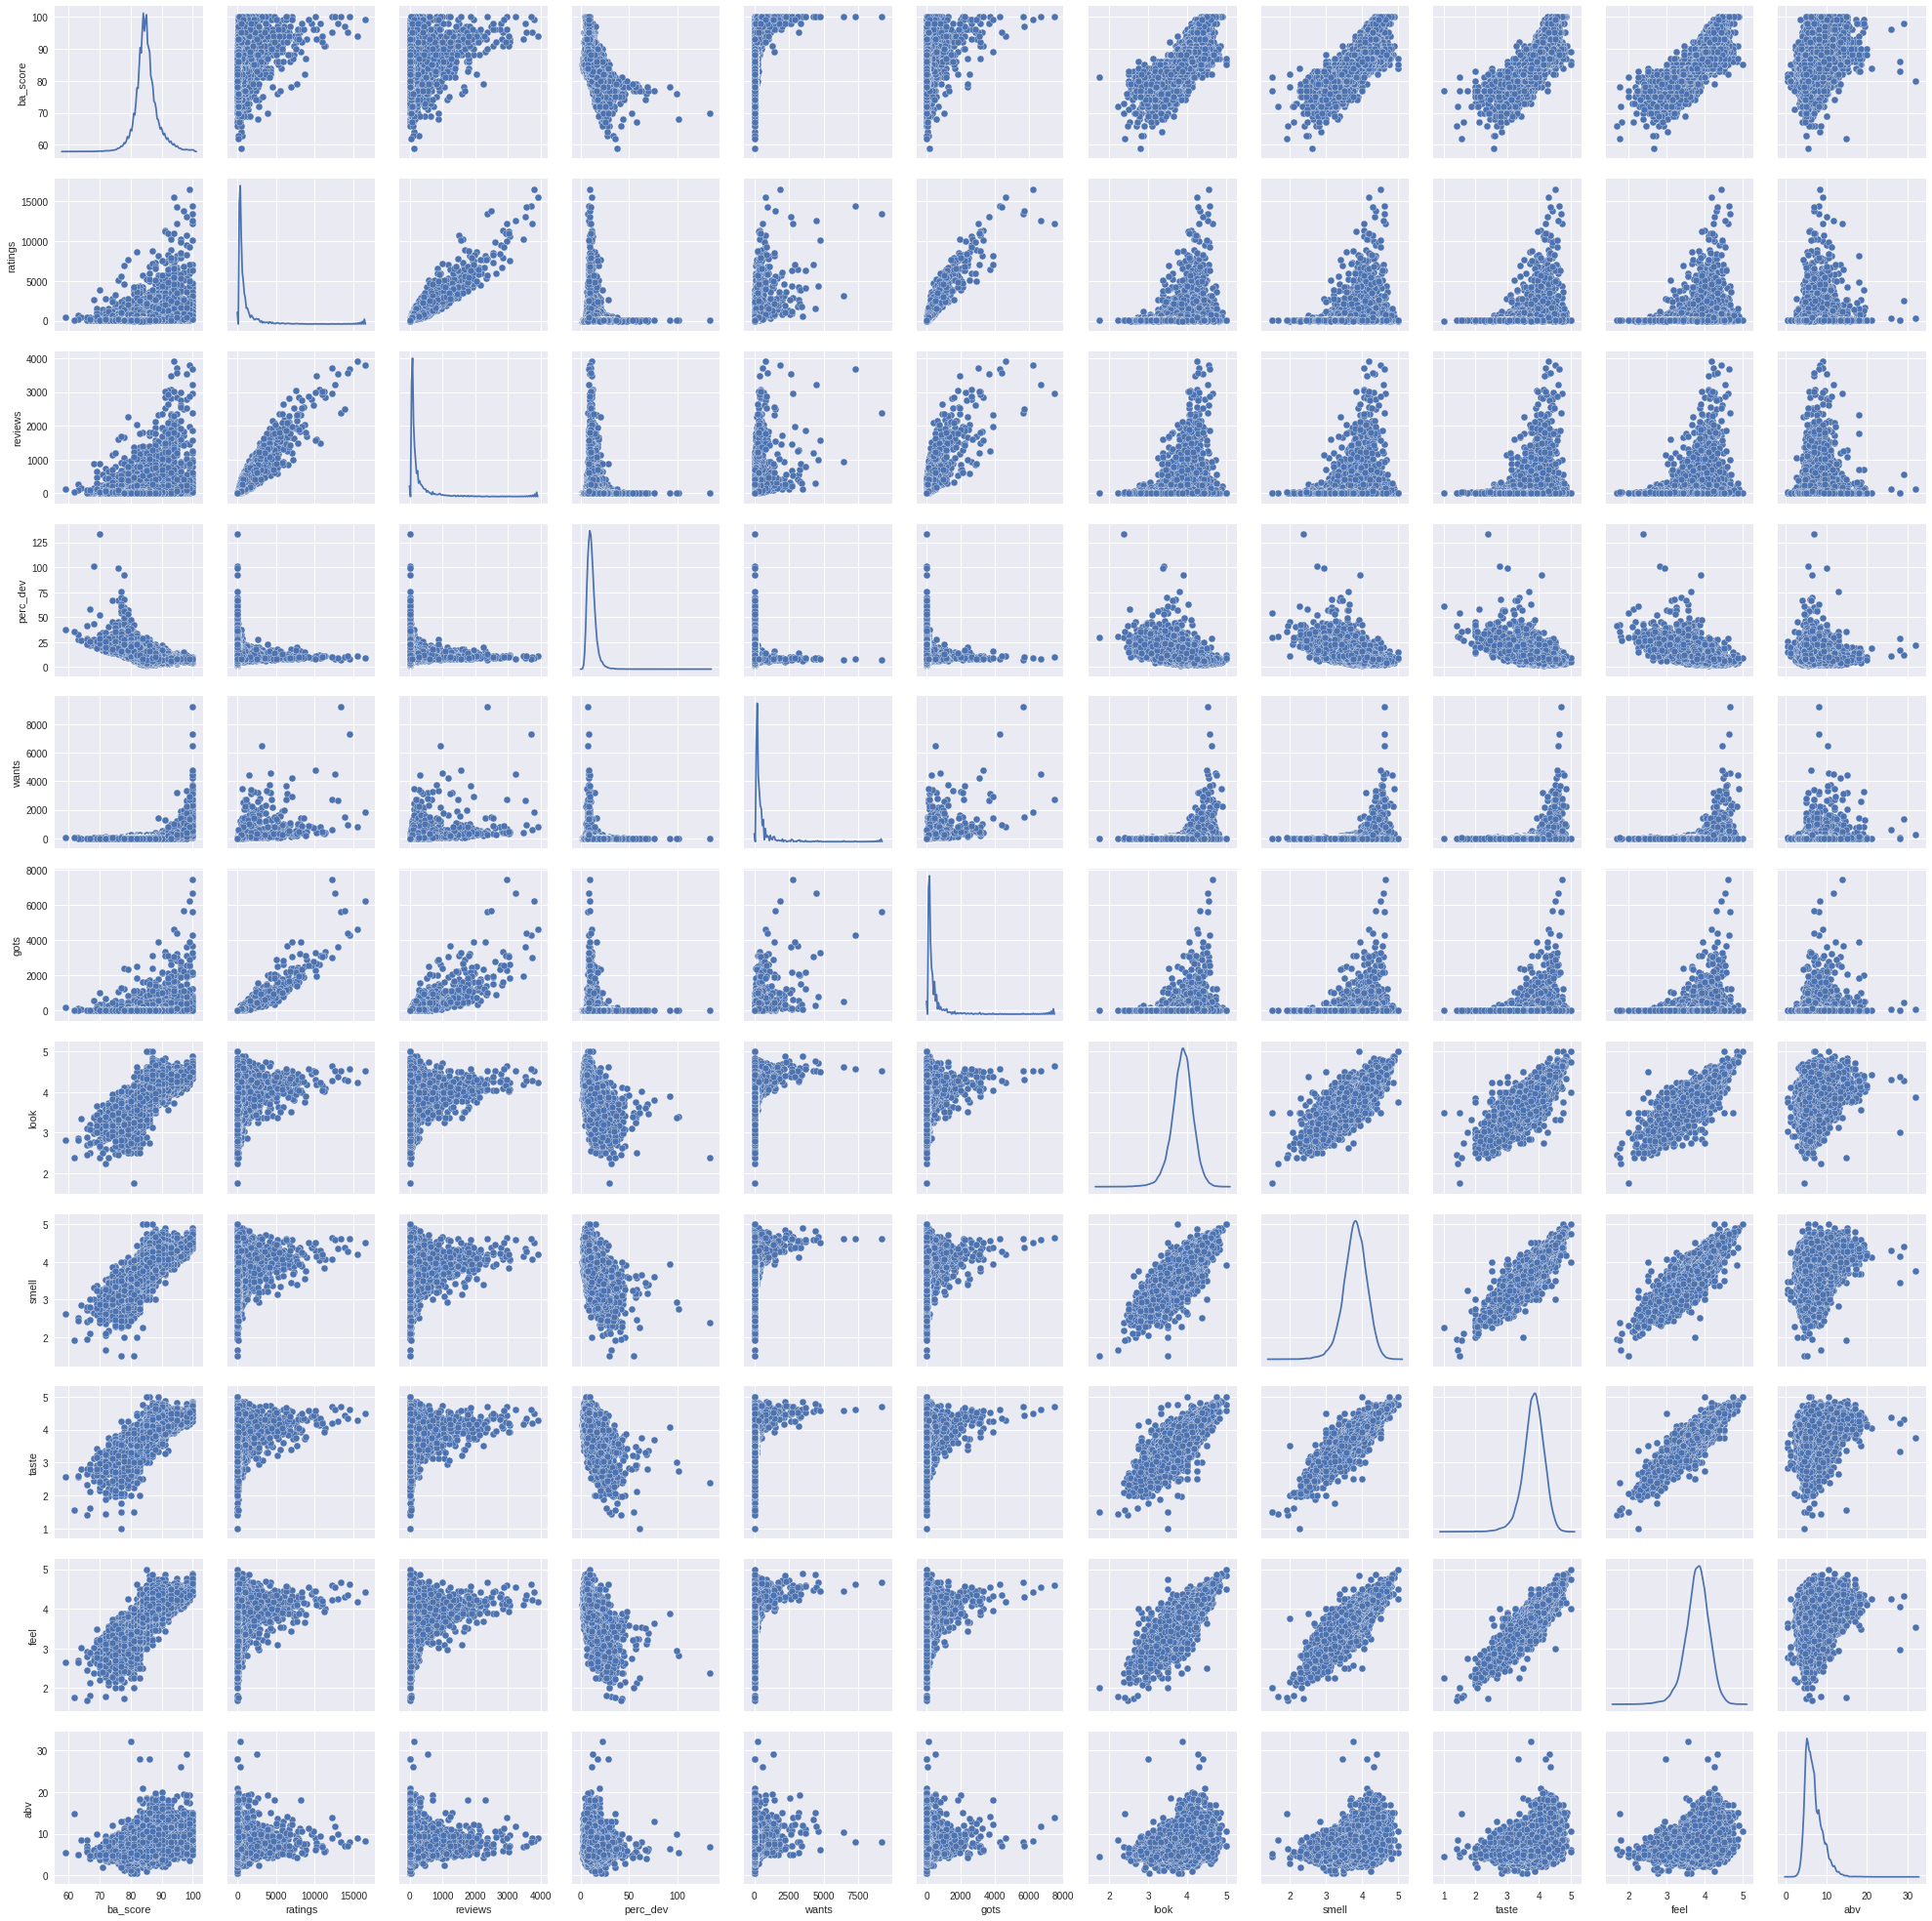

In [6]:
sns.pairplot(numeric_beer_data, diag_kind='kde')

# Initial model testing

In [7]:
from sklearn import dummy, linear_model, ensemble, tree, model_selection


In [8]:
X, y = numeric_beer_data.drop('ba_score', axis=1), numeric_beer_data['ba_score']
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y,test_size = .1, random_state=42)

In [9]:
models = {}
parameters = {}

models['dummy'] = dummy.DummyRegressor()
models['linear_model'] = linear_model.LinearRegression()
models['ridge_model'] = linear_model.Ridge()
models['lasso_model'] = linear_model.Lasso(alpha=.1)
models['robust_regression'] = linear_model.SGDRegressor(loss='huber',n_iter=5)
models['eps_insensitive'] = linear_model.SGDRegressor(loss='epsilon_insensitive',n_iter=5)


models['cart'] = tree.DecisionTreeRegressor(max_depth=7)
models['extratrees'] = tree.ExtraTreeRegressor(max_depth=7)
models['randomForest'] = ensemble.RandomForestRegressor()
models['adaboostedTrees'] = ensemble.AdaBoostRegressor()
models['gradboostedTrees'] = ensemble.GradientBoostingRegressor()


for name,model in models.items():
    scores = model_selection.cross_val_score(model, X_train, y_train, n_jobs=1)
    print('Model: '+name)
    print("Score: " + str(np.mean(scores)))
    print("STDev:" + str(np.std(scores)) + "\n")

Model: dummy
Score: -0.000103404572072
STDev:7.31224655569e-05

Model: linear_model
Score: 0.711194393392
STDev:0.00526111762016

Model: ridge_model
Score: 0.71119466446
STDev:0.00526446870524

Model: lasso_model
Score: 0.695108909065
STDev:0.00711469681849

Model: robust_regression
Score: -31.3744871817
STDev:21.1679996923

Model: eps_insensitive
Score: -1230.35395638
STDev:820.513048202

Model: cart
Score: 0.839536553971
STDev:0.00216244091879

Model: extratrees
Score: 0.738167649406
STDev:0.0389451481523

Model: randomForest
Score: 0.875951222337
STDev:0.00148847238021

Model: adaboostedTrees
Score: 0.789498101302
STDev:0.00671259334272

Model: gradboostedTrees
Score: 0.882636653568
STDev:0.00126371114165



# Check importance of features in several models

## Linear Regression

In [24]:
linear_basic = models['linear_model'].fit(X_train, y_train)
coefs_linear = linear_basic.coef_
intercept_linear = linear_basic.intercept_
sorted(zip(X_train.columns, coefs_linear), key = lambda x: x[1], reverse=True)

[('smell', 2.3798138433842295),
 ('taste', 2.3216377339508449),
 ('feel', 1.5730942246818087),
 ('look', 1.4782049818729703),
 ('abv', 0.10638001302431219),
 ('ratings', 0.0039178468479669016),
 ('wants', 0.0032829083359720516),
 ('reviews', -0.0056437248602692492),
 ('gots', -0.0064985937283053375),
 ('perc_dev', -0.10196366241296345)]

In [12]:
linear_basic.score(X_test, y_test)

0.71791426043611106

## Scale features

In [14]:
from sklearn.preprocessing import StandardScaler

std = StandardScaler()
std.fit(X_train)

X_tr = std.transform(X_train)
X_te = std.transform(X_test)

## Scaled Linear Regression

In [30]:
linear_sc = models['linear_model'].fit(X_tr, y_train)
linear_coefs_sc = linear_sc.coef_
linear_intercept_sc = linear_sc.intercept_
sorted(zip(X_train.columns, coefs_linear_sc), key = lambda x: x[1], reverse=True)

[('ratings', 2.3428424308255673),
 ('taste', 0.77357575698650849),
 ('smell', 0.77235701055015848),
 ('wants', 0.50248731942898162),
 ('feel', 0.48630656679605799),
 ('look', 0.40065610161760462),
 ('abv', 0.22125227637632647),
 ('perc_dev', -0.4693923443567326),
 ('reviews', -0.98362163937144909),
 ('gots', -1.0947732012320732)]

In [16]:
models['linear_model'].score(X_te, y_test)

0.71791426043611117

## Lasso Regression

In [17]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler



alphavec = 10**np.linspace(-3,9,27)

lasso_model = LassoCV(alphas = alphavec, cv=10)
lasso_model.fit(X_tr,y_train)

coefs_lasso = lasso_model.coef_
sorted(zip(X_train.columns, coefs_lasso), key = lambda x: x[1], reverse=True)

[('ratings', 2.1617148994882425),
 ('smell', 0.77496599373804276),
 ('taste', 0.7730105883021785),
 ('wants', 0.50178213427493501),
 ('feel', 0.48841048160741257),
 ('look', 0.40030457729892055),
 ('abv', 0.21711907596080487),
 ('perc_dev', -0.46729997150999586),
 ('reviews', -0.88179721952111478),
 ('gots', -1.0063141238765014)]

In [18]:
lasso_model.alpha_

0.0028942661247167516

In [19]:
lasso_model.score(X_te, y_test)

0.7175419130335261

This is just returning linear regression. It looks like the number of ratings is highly predictive of a beer getting a good score. In other words, well-known beer is likely to be highly rated (Word gets around?) We can plot these in terms of their coefficients.

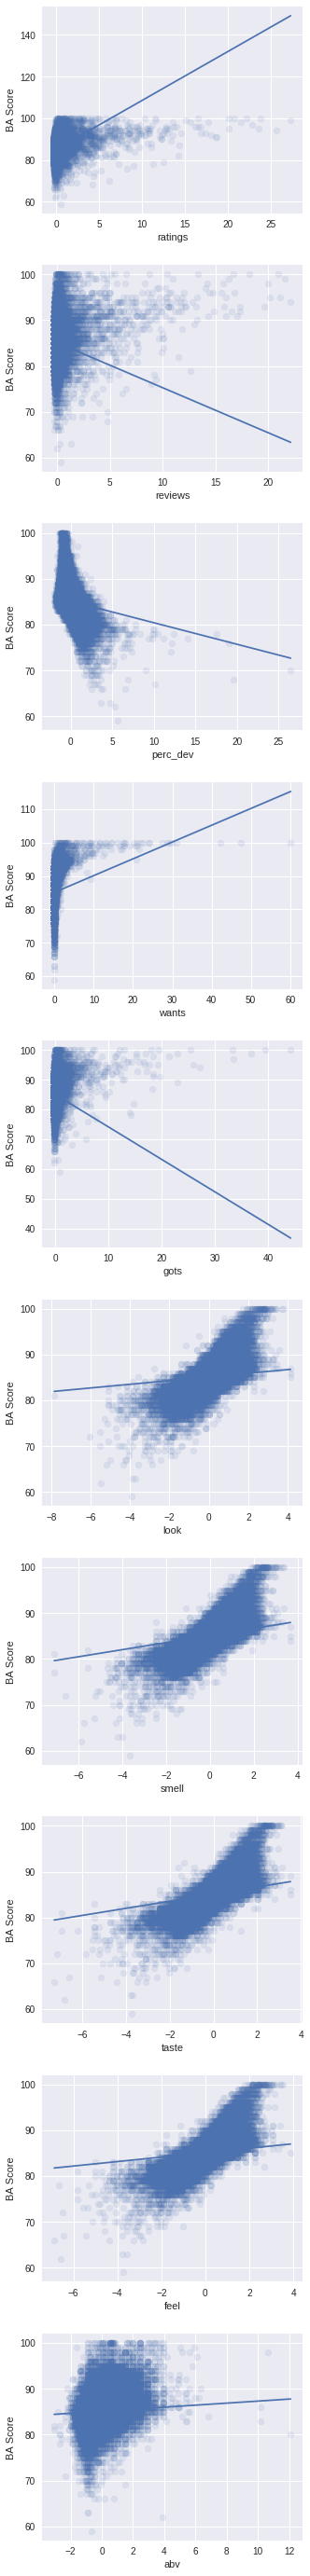

In [32]:
columns = X_train.columns
num_columns = len(columns)

fig, axes = plt.subplots(num_columns, 1, figsize=(5, 5*num_columns))
fig.subplots_adjust(hspace=0.25)

for i, column in enumerate(columns):
    current_x = X_tr[:, i]
    x_min = current_x.min()
    x_max = current_x.max()
    
    x_linear = np.linspace(x_min, x_max, 1001)
    axes[i].scatter(current_x, y_train, alpha=0.1)
    axes[i].plot(x_linear, linear_coefs_sc[i]*x_linear + linear_intercept_sc)
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('BA Score')

## Random forest

In [33]:
coefs_rf = models['randomForest'].fit(X_train,y_train).feature_importances_
sorted(zip(X.columns,coefs_rf), key = lambda x:x[1], reverse=True)

[('taste', 0.53005646619635671),
 ('wants', 0.17308404210750217),
 ('ratings', 0.074914771028025559),
 ('feel', 0.061803488010293103),
 ('perc_dev', 0.060554403479804855),
 ('smell', 0.050186661067875928),
 ('reviews', 0.013646040257670725),
 ('look', 0.013420728276478739),
 ('abv', 0.01184621419361633),
 ('gots', 0.010487185382375865)]

In [35]:
beer_data['style'].unique()

array(['AmericanWildAle', 'AmericanDoubleImperialIPA', 'AmericanPaleAle',
       'BalticPorter', 'BieredeGarde', 'AmericanBlondeAle',
       'AmericanPaleWheatAle', 'BlackAndTan', 'AmericanIPA',
       'AmericanBarleywine', 'OldAle', 'AmericanPorter',
       'SaisonFarmhouseAle', 'BelgianStrongDarkAle', 'OatmealStout',
       'AmericanBlackAle', 'MilkSweetStout', 'AmericanBrownAle',
       'AmericanStout', 'AmericanAmberRedAle', 'Quadrupel', 'BelgianIPA',
       'BelgianStrongPaleAle', 'BelgianPaleAle', 'Dubbel', 'Tripel',
       'EnglishBitter', 'Altbier', 'EnglishStrongAle',
       'AmericanDoubleImperialStout', 'Witbier', 'Hefeweizen',
       'BerlinerWeissbier', 'EnglishPorter', 'ForeignExportStout',
       'EnglishPaleAle', 'Wheatwine', 'ScottishAle', 'Weizenbock',
       'EnglishBrownAle', 'EnglishIndiaPaleAle', 'ScotchAleWeeHeavy',
       'RussianImperialStout', 'EnglishBarleywine', 'WinterWarmer',
       'AmericanStrongAle', 'ExtraSpecialStrongBitter', 'CreamAle',
       'Irish